In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# Set max columns
pd.set_option('display.max_columns', None)

# save pickle
from inspect import getblock
import pickle

## **1. Business Problem**

### **Latar Belakang**

Manajemen  perusahaan telekomunikasi PT. Nusantara Telekomindo ingin mengurangi tingkat churn pelanggan mereka. Churn pelanggan adalah situasi di mana pelanggan berhenti menggunakan layanan perusahaan dan beralih ke penyedia lain. Tingkat churn yang tinggi dapat berdampak negatif pada pendapatan dan pertumbuhan perusahaan.

Selama ini perusahaan mengeluarkan biaya promosi ke seluruh pelanggan, tanpa mengetahui siapa saja pelanggan yang benar-benar berisiko untuk churn. Hal ini menyebabkan pemborosan anggaran promosi, karena promosi diberikan kepada pelanggan yang sebenarnya tidak berisiko untuk churn.

### **Problem Statement**
Saat ini perusahaan tidak memiliki suatu alat atau sistem yang mampu memprediksi pelanggan mana yang berisiko tinggi untuk churn. Oleh karena itu, perusahaan ingin mengembangkan model prediksi churn pelanggan yang dapat mengidentifikasi pelanggan yang berisiko tinggi untuk churn, sehingga perusahaan dapat fokus memberikan promosi kepada pelanggan tersebut.

Diperlukan suatu model machine learning yang dapat membantu perusahaan dalam:
1. Memprediksi pelanggan yang berisiko tinggi untuk churn.
2. Mengoptimalkan anggaran promosi dengan menargetkan pelanggan yang berisiko tinggi untuk churn.
3. Mengurangi pembengkakan biaya promosi yang tidak efektif.

### **Metric Evaluation**
- Cost FP (False Positive) = Biaya promosi yang diberikan kepada pelanggan yang tidak berisiko churn = $100
- Cost FN (False Negative) = Biaya kehilangan pelanggan yang berisiko churn = $500

Karena cost FN lebih besar daripada cost FP, maka model yang dikembangkan harus meminimalkan jumlah FN sebanyak mungkin, sambil tetap menjaga jumlah FP pada tingkat yang dapat diterima.

Metrik evaluasi yang akan digunakan dalam model ini adalah F2-score, agar kita memberi bobot lebih pada FN sambil tetap memerhatikan FP.




### **Goals**
1. Mengembangkan model machine learning yang bisa memprediksi pelanggan yang berisiko untuk churn berdasarkan data historis pelanggan.
2. Mengurangi kerugian biaya akibat churn pelanggan dengan menargetkan promosi kepada pelanggan yang berisiko untuk churn.
3. Meningkatkan efisiensi anggaran promosi dengan mengurangi pemborosan pada pelanggan yang tidak berisiko churn.

## **2. Load Dataset**

In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


### **Data Understanding**

In [3]:
# Standardize column names
df.columns = df.columns.str.lower()
df.columns

Index(['dependents', 'tenure', 'onlinesecurity', 'onlinebackup',
       'internetservice', 'deviceprotection', 'techsupport', 'contract',
       'paperlessbilling', 'monthlycharges', 'churn'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   onlinesecurity    4930 non-null   object 
 3   onlinebackup      4930 non-null   object 
 4   internetservice   4930 non-null   object 
 5   deviceprotection  4930 non-null   object 
 6   techsupport       4930 non-null   object 
 7   contract          4930 non-null   object 
 8   paperlessbilling  4930 non-null   object 
 9   monthlycharges    4930 non-null   float64
 10  churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [5]:
pd.set_option('display.max_colwidth', 0)
list_item = []
for col in df.columns :
    list_item.append( [col, df[col].nunique(), df[col].unique()])

info_tabel = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=list_item)
info_tabel

,Column Name,Number of Unique,Unique Sample
0,dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,onlinesecurity,3,"[No, Yes, No internet service]"
3,onlinebackup,3,"[No, Yes, No internet service]"
4,internetservice,3,"[DSL, Fiber optic, No]"
5,deviceprotection,3,"[Yes, No internet service, No]"
6,techsupport,3,"[Yes, No, No internet service]"
7,contract,3,"[Month-to-month, Two year, One year]"
8,paperlessbilling,2,"[Yes, No]"
9,monthlycharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


#### **Data Overview**
1. Data terdiri dari 4930 baris dan 11 kolom.
2. Terdapat 10 fitur dan 1 fitur target (churn).
3. Fitur terdiri dari 2 data tipe numerik dan 9 data tipe kategorikal.

#### **Penjelasan isi dari tiap Kolom**
---
##### **Features**
---
-	Dependents: menunjukkan apakah pelanggan memiliki tanggungan atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**
    * **Yes** : Pelanggan memiliki tanggungan.
    * **No** : Tidak memiliki tanggungan.
---
-	Tenure: menunjukkan jumlah bulan pelanggan telah berlangganan dengan perusahaan.
    * Tipe data: **int64** (numerik)
    * Nilai unik contoh: **1**, **2**, **3**, ..., **72** (73 nilai unik)
    * Angka lebih besar menunjukkan pelanggan telah berlangganan lebih lama.
---
-	OnlineSecurity: menunjukkan apakah pelanggan memiliki keamanan online atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**, **No internet service**
    * **Yes** : Pelanggan memiliki keamanan online.
    * **No** : Pelanggan memiliki keamanan online, tetapi tidak digunakan.
    * **No internet service** : Pelanggan tidak memiliki keamanan online.
---
-	OnlineBackup: menunjukkan apakah pelanggan memiliki layanan cadangan online atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**, **No internet service**
    * **Yes** : Pelanggan memiliki layanan cadangan online.
    * **No** : Pelanggan memiliki layanan cadangan online, tetapi tidak digunakan.
    * **No internet service** : Pelanggan tidak memiliki layanan cadangan online.
---
-	InternetService: menunjukkan apakah pelanggan berlangganan layanan internet atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **DSL**, **Fiber optic**, **No**
    * **DSL** : Pelanggan berlangganan layanan internet dengan teknologi DSL.
    * **Fiber optic** : Pelanggan berlangganan layanan internet dengan teknologi Fiber Optic.
    * **No** : Pelanggan tidak berlangganan layanan internet.
---
-	DeviceProtection: menunjukkan apakah pelanggan memiliki perlindungan perangkat atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**, **No internet service**
    * **Yes** : Pelanggan memiliki perlindungan perangkat.
    * **No** : Pelanggan memiliki perlindungan perangkat, tetapi tidak digunakan.
    * **No internet service** : Pelanggan tidak memiliki perlindungan perangkat.
---
-	TechSupport: menunjukkan apakah pelanggan memiliki dukungan teknis atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**, **No internet service**
    * **Yes** : Pelanggan memiliki dukungan teknis.
    * **No** : Pelanggan memiliki dukungan teknis, tetapi tidak digunakan.
    * **No internet service** : Pelanggan tidak memiliki dukungan teknis.
---
-	Contract: menunjukkan jenis kontrak berdasarkan durasi.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Month-to-month**, **One year**, **Two year**
    * **Month-to-month** : Pelanggan memiliki kontrak bulanan.
    * **One year** : Pelanggan memiliki kontrak satu tahun.
    * **Two year** : Pelanggan memiliki kontrak dua tahun.
---
-	PaperlessBilling: menunjukkan apakah pelanggan menggunakan penagihan tanpa kertas atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**
    * **Yes** : Pelanggan menggunakan penagihan tanpa kertas.
    * **No** : Pelanggan tidak menggunakan penagihan tanpa kertas.
---
-	MonthlyCharges: menunjukkan jumlah biaya untuk layanan setiap bulan.
    * Tipe data: **float64** (numerik)
    * Nilai unik contoh: **72.9**, **82.65** (1422 nilai unik)
    * Angka lebih besar menunjukkan biaya bulanan yang lebih tinggi.
---
##### **Target**
---
-	Churn: Menunjukkan apakah pelanggan berhenti berlangganan atau tidak.
    * Tipe data: **object** (kategorikal)
    * Nilai unik: **Yes**, **No**
    * **Yes** → Pelanggan berhenti berlangganan.
    * **No** → Pelanggan tetap berlangganan.


### **Data Cleaning**

#### **Missing Value checking**

In [6]:
df.isnull().sum()

dependents          0
tenure              0
onlinesecurity      0
onlinebackup        0
internetservice     0
deviceprotection    0
techsupport         0
contract            0
paperlessbilling    0
monthlycharges      0
churn               0
dtype: int64

#### **Duplicate checking**

In [7]:
df.duplicated().sum()

np.int64(77)

In [8]:
df.drop_duplicates(inplace=True)

#### **Merubah value pada kolom churn dari Yes/No menjadi 1/0**

In [9]:
df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})

## **3. Exploratory Data Analysis**

### **Analisa Deskriptif**

In [10]:
df.describe()

,tenure,monthlycharges,churn
count,4853.000000,4853.000000,4853.000000
mean,32.679992,65.321543,0.265403
std,24.395554,29.783655,0.441593
min,0.000000,18.800000,0.000000
25%,9.000000,40.050000,0.000000
50%,29.000000,70.600000,0.000000
75%,56.000000,90.050000,1.000000
max,72.000000,118.650000,1.000000


### **Checking Outlier**

In [11]:
#kolom tenure
Q1 = df['tenure'].quantile(0.25)
Q3 = df['tenure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['tenure'] < lower_bound) | (df['tenure'] > upper_bound)]
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print(f"Jumlah outlier tenure: {len(outliers)}")

Lower bound: -61.5
Upper bound: 126.5
Jumlah outlier tenure: 0


In [12]:
#kolom monthlycharges
Q1 = df['monthlycharges'].quantile(0.25)
Q3 = df['monthlycharges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['monthlycharges'] < lower_bound) | (df['monthlycharges'] > upper_bound)]
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print(f"Jumlah outlier monthlycharges: {len(outliers)}")

Lower bound: -34.95
Upper bound: 165.05
Jumlah outlier monthlycharges: 0


Tidak ada outlier pada kolom numerik.

### **Distribusi Data Numerik**

In [13]:
num_cols = ['tenure', 'monthlycharges']

In [14]:
%matplotlib inline

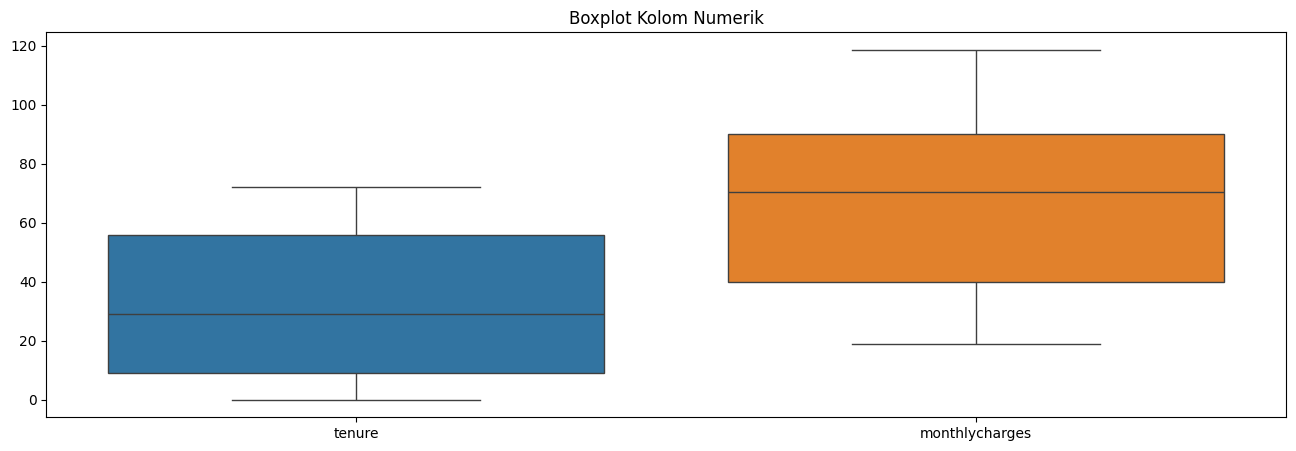

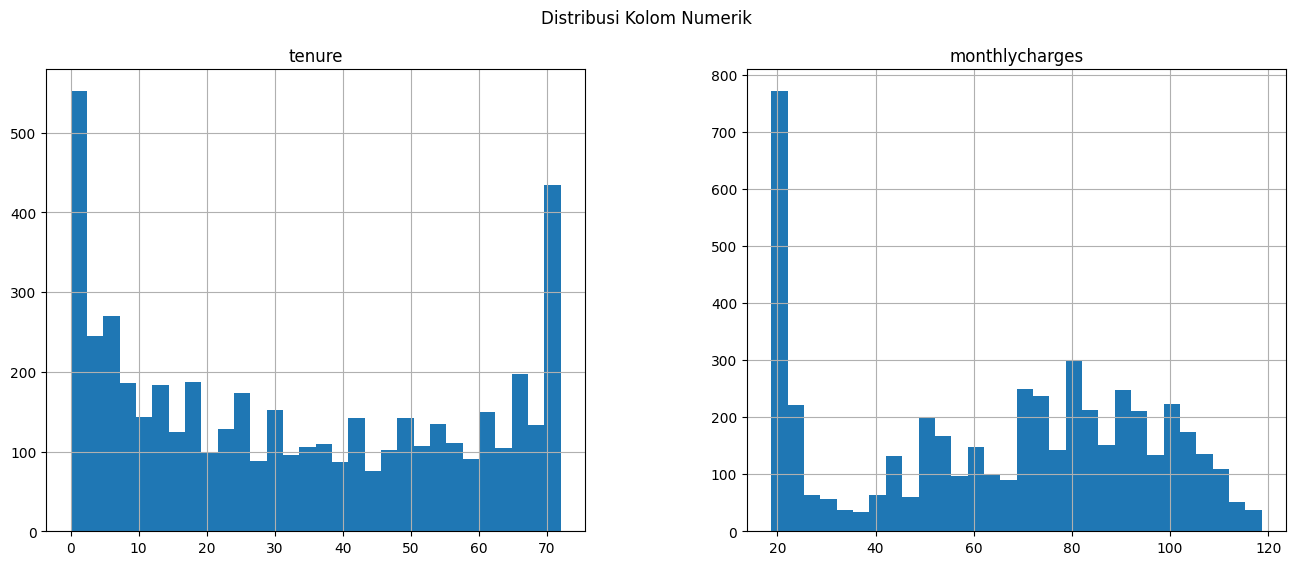

In [15]:
plt.figure(figsize=(16,5))
sns.boxplot(data=df[num_cols])
plt.title('Boxplot Kolom Numerik')
plt.show()

df[num_cols].hist(figsize=(16,6), bins=30)
plt.suptitle('Distribusi Kolom Numerik')
plt.show()

- Berdasarkan analisa, **tidak ditemukan outlier pada kolom numerik 'tenure' dan 'monthlycharges'.**
- Kolom numerik **tidak terdistribusi normal.**

### **Distribusi Data Kategorikal**

In [16]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

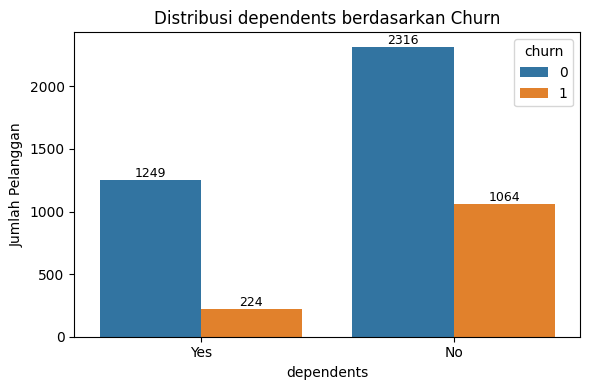

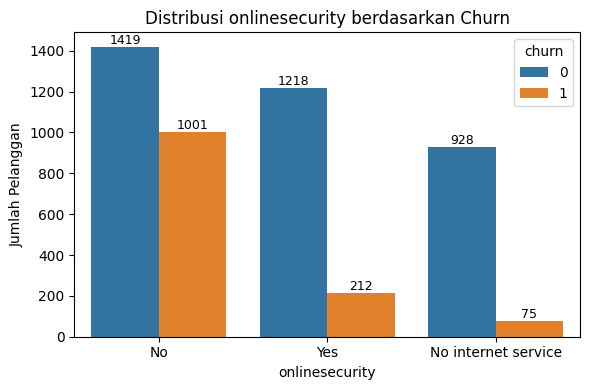

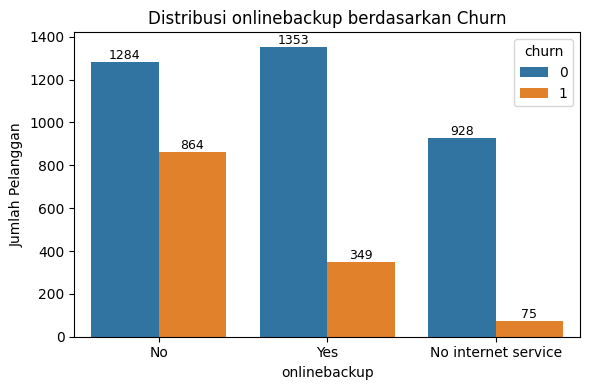

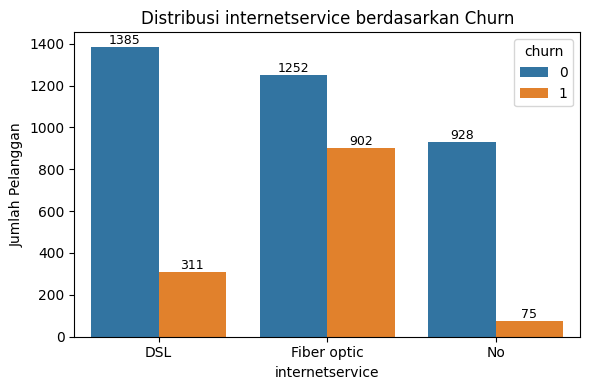

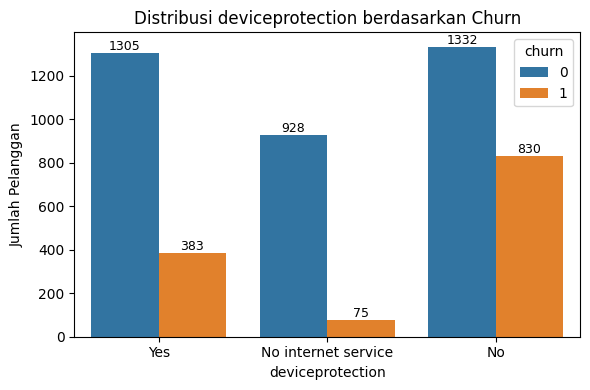

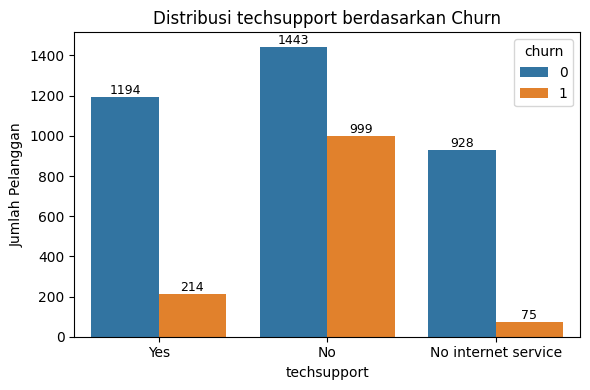

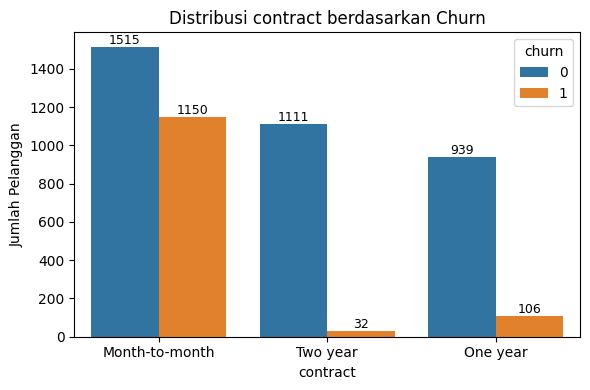

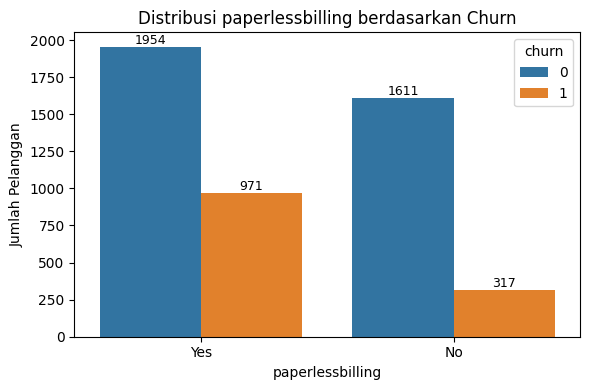

In [17]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df, x=col, hue='churn')
    plt.title(f'Distribusi {col} berdasarkan Churn')
    plt.xticks(rotation=0)
    plt.xlabel(col)
    plt.ylabel("Jumlah Pelanggan")

    #Tambahkan label count di atas tiap bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    plt.tight_layout()
    plt.show()

- dependents : Target promosi bisa difokuskan pada pelanggan yang belum memiliki tanggungan (No).
- onlinesecurity : Menawarkan layanan keamanan bisa mengurangi risiko churn.
- onlinebackup : Menawarkan layanan cadangan online bisa mengurangi risiko churn.
- internetservice : Pelanggan dengan layanan Fiber optic memiliki risiko churn lebih tinggi dibandingkan DSL atau tanpa layanan internet, bisa disebabkan oleh kecepatan internet yang lebih tinggi namun biaya yang juga lebih mahal.
- deviceprotection : Menawarkan perlindungan perangkat bisa mengurangi risiko churn.
- techsupport : Menawarkan dukungan teknis bisa mengurangi risiko churn.
- contract : Pelanggan dengan kontrak jangka panjang (One year, Two year) memiliki risiko churn lebih rendah dibandingkan kontrak bulanan (Month-to-month).
- paperlessbilling : Pelanggan yang menggunakan penagihan tanpa kertas (Yes) memiliki risiko churn lebih tinggi dibandingkan yang tidak (No).

### **Proporsi Churn pada Dataset**

In [18]:
df['churn'].value_counts()

churn
0    3565
1    1288
Name: count, dtype: int64

In [19]:
df['churn'].value_counts() / len(df)

churn
0    0.734597
1    0.265403
Name: count, dtype: float64

Proporsi churn pada dataset dapat disimpulkan : 
- Sekitar **26.5% pelanggan berhenti berlangganan (churn = Yes)**, sedangkan sekitar **73.5% pelanggan tetap berlangganan (churn = No).** 
- Dapat disimpulkan **dataset bersifat imbalanced**, bisa menggunakan teknik oversampling atau undersampling pada tahap modeling nanti.

## **4. Define X and y**

In [20]:
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

## **5. Data Splitting**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **6. Data Preprocessing**

### **Memisahkan fitur numerik dan kategorikal**

In [22]:
numeric_features = ['tenure', 'monthlycharges']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [23]:
numeric_features, categorical_features

(['tenure', 'monthlycharges'],
 ['dependents',
  'onlinesecurity',
  'onlinebackup',
  'internetservice',
  'deviceprotection',
  'techsupport',
  'contract',
  'paperlessbilling'])

### **Membuat pipeline untuk fitur numerik dan kategorikal**

In [24]:
#numeric pipeline with scaling
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
]).set_output(transform='pandas')

In [25]:
#numeric pipeline without scaling
numeric_pipeline2 = Pipeline(steps=[]).set_output(transform='pandas')

- StandardScaler digunakan karena pada data numerik tidak ada outlier dan tidak terdistribusi normal.

In [26]:
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
]).set_output(transform='pandas')

- OneHotEncoder digunakan karena pada kolom kategorikal tidak ada urutan/hierarki, juga unique value maksimal hanya 3.

### **Menyatukan pipeline menggunakan ColumnTransformer**

In [27]:
#preprocessor with scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='passthrough'
).set_output(transform='pandas')

In [28]:
#preprocessor without scaling
preprocessor2 = ColumnTransformer(
	transformers=[
		('num', 'passthrough', numeric_features),
		('cat', categorical_pipeline, categorical_features)
	], remainder='passthrough'
).set_output(transform='pandas')

In [29]:
preprocessor2

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'first'
,sparse_output,False


In [30]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [31]:
y_train.value_counts(normalize=True)

churn
0    0.734673
1    0.265327
Name: proportion, dtype: float64

## **7. Cross Validation**

In [32]:
#define algo
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
#random forest
rf = RandomForestClassifier(random_state=42)
#gradient boosting
adaboost = AdaBoostClassifier(random_state=42)
gboost = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [33]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [34]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
start_time = time.time()
#cross val scaling
list_model = [knn]
list_all_score = []
list_mean_score = []
list_std = []

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = skf,
                    scoring = f2_scorer)

    
    # recall
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())
    
end_time = time.time()
elapsed = end_time - start_time
print(f"Total running time: {elapsed:.2f} seconds") 

Total running time: 2.15 seconds


In [36]:
#cross val tanpa scaling
list_model2 = [tree, rf, adaboost, gboost, xgboost, logreg]
list_all_score2 = []
list_mean_score2 = []
list_std2 = []
list_time = []

for model in list_model2:
    start = time.time()
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', preprocessor2),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = skf,
                    scoring = f2_scorer)
    end = time.time()
    
    # recall
    list_all_score2.append(crossval.round(2))
    list_mean_score2.append(crossval.mean())
    list_std2.append(crossval.std())
    list_time.append(round(end - start, 2))

In [37]:
df_cv = pd.DataFrame({
    'Model': [m.__class__.__name__ for m in list_model],
    'All F2 Scores': list_all_score,
    'Mean F2': list_mean_score,
    'Std F2': list_std,
    'Time (s)' : round(elapsed,2)
}).sort_values(by=['Mean F2', 'Std F2'], ascending=[False, True]).reset_index(drop=True)
df_cv

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,KNeighborsClassifier,"[0.49, 0.47, 0.52, 0.53, 0.55]",0.512257,0.027338,2.15


In [38]:
df_cv2 = pd.DataFrame({
    'Model': [m.__class__.__name__ for m in list_model2],
    'All F2 Scores': list_all_score2,
    'Mean F2': list_mean_score2,
    'Std F2': list_std2,
    'Time (s)': list_time
}).sort_values(by=['Mean F2', 'Std F2'], ascending=[False, True]).reset_index(drop=True)
df_cv2

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,LogisticRegression,"[0.56, 0.54, 0.54, 0.54, 0.52]",0.541610,0.010285,0.21
1,GradientBoostingClassifier,"[0.53, 0.46, 0.54, 0.53, 0.53]",0.519180,0.027950,1.27
2,XGBClassifier,"[0.49, 0.51, 0.49, 0.49, 0.55]",0.504778,0.023998,0.56
3,AdaBoostClassifier,"[0.45, 0.45, 0.5, 0.55, 0.51]",0.492104,0.035961,0.53
4,DecisionTreeClassifier,"[0.51, 0.46, 0.48, 0.46, 0.5]",0.481962,0.023422,0.14
5,RandomForestClassifier,"[0.46, 0.42, 0.48, 0.47, 0.51]",0.467861,0.029928,1.25


In [39]:
df_cv_all = pd.concat([df_cv, df_cv2], ignore_index=True).sort_values(by=['Mean F2', 'Std F2'], ascending=[False, True]).reset_index(drop=True)
df_cv_all

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,LogisticRegression,"[0.56, 0.54, 0.54, 0.54, 0.52]",0.541610,0.010285,0.21
1,GradientBoostingClassifier,"[0.53, 0.46, 0.54, 0.53, 0.53]",0.519180,0.027950,1.27
2,KNeighborsClassifier,"[0.49, 0.47, 0.52, 0.53, 0.55]",0.512257,0.027338,2.15
3,XGBClassifier,"[0.49, 0.51, 0.49, 0.49, 0.55]",0.504778,0.023998,0.56
4,AdaBoostClassifier,"[0.45, 0.45, 0.5, 0.55, 0.51]",0.492104,0.035961,0.53
5,DecisionTreeClassifier,"[0.51, 0.46, 0.48, 0.46, 0.5]",0.481962,0.023422,0.14
6,RandomForestClassifier,"[0.46, 0.42, 0.48, 0.47, 0.51]",0.467861,0.029928,1.25


## **8. Cross Validation + Resampling**

In [40]:
resamplers = {
    'SMOTE': SMOTE(sampling_strategy='minority', random_state=42),
    'RandomOver': RandomOverSampler(sampling_strategy='minority', random_state=42),
    'RandomUnder': RandomUnderSampler(sampling_strategy='majority', random_state=42)
}

In [41]:
preprocessors = {
    'with_scaling': preprocessor,
    'without_scaling': preprocessor2
}

In [42]:
models = {
    'with_scaling': [knn],
    'without_scaling': [tree, rf, adaboost, gboost, xgboost, logreg]
}

In [43]:
results = []

for prep_name, prep in preprocessors.items():
    for res_name, res in resamplers.items():
        for model in models[prep_name]:
            start = time.time()
            pipe = Pipeline([
                ('preprocessing', prep),
                ('resampling', res),
                ('modeling', model)
            ])
            
            scores = cross_val_score(
                estimator=pipe,
                X=X_train,
                y=y_train,
                cv=skf,
                scoring=f2_scorer
            )
            end = time.time()
            
            results.append({
                'Resampling': res_name,
                'Model': model.__class__.__name__,
                'All F2 Scores': scores.round(2).tolist(),
                'Mean F2 Scores': scores.mean(),
                'Std F2 Scores': scores.std(),
                'Time (s)' : (round(end - start, 2))
            })

df_results = pd.DataFrame(results).sort_values(by=['Mean F2 Scores', 'Std F2 Scores'], ascending=[False, True]).reset_index(drop=True)
df_results

,Resampling,Model,All F2 Scores,Mean F2 Scores,Std F2 Scores,Time (s)
0,RandomUnder,AdaBoostClassifier,"[0.74, 0.71, 0.72, 0.7, 0.72]",0.718633,0.012287,0.47
1,RandomOver,AdaBoostClassifier,"[0.73, 0.7, 0.72, 0.71, 0.73]",0.717575,0.012064,0.63
2,SMOTE,LogisticRegression,"[0.69, 0.69, 0.73, 0.72, 0.73]",0.714315,0.016446,0.29
3,RandomOver,GradientBoostingClassifier,"[0.71, 0.68, 0.73, 0.71, 0.73]",0.713247,0.019652,1.62
4,RandomUnder,LogisticRegression,"[0.7, 0.69, 0.72, 0.72, 0.72]",0.712577,0.012545,0.19
5,RandomOver,LogisticRegression,"[0.7, 0.69, 0.73, 0.72, 0.72]",0.712495,0.012812,0.24
6,RandomUnder,GradientBoostingClassifier,"[0.71, 0.68, 0.73, 0.71, 0.73]",0.711867,0.018026,0.88
7,RandomUnder,XGBClassifier,"[0.68, 0.64, 0.69, 0.65, 0.68]",0.666526,0.016519,0.32
8,SMOTE,AdaBoostClassifier,"[0.68, 0.61, 0.69, 0.68, 0.66]",0.664615,0.027489,0.77
9,RandomUnder,KNeighborsClassifier,"[0.66, 0.62, 0.69, 0.64, 0.71]",0.663559,0.030213,0.23


## **9. Cross Validation + Penalized Model (class_weight = "balanced")**

In [44]:
logreg_bal = LogisticRegression(class_weight='balanced', random_state=42)
tree_bal = DecisionTreeClassifier(class_weight='balanced', random_state=42)
rf_bal = RandomForestClassifier(class_weight='balanced', random_state=42)

In [45]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
adaboost_bal = AdaBoostClassifier(estimator=base_tree, random_state=42)

In [46]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
ratio
xgboost_bal = XGBClassifier(scale_pos_weight=ratio, random_state=42)

In [47]:
#cross val tanpa scaling
list_model_bal = [tree_bal, rf_bal, adaboost_bal, xgboost_bal, logreg_bal]
list_all_score_bal = []
list_mean_score_bal = []
list_std_bal = []
list_time = []

for model in list_model_bal:
    start = time.time()
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', preprocessor2),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = skf,
                    scoring = f2_scorer)
    end = time.time()
    
    # recall
    list_all_score_bal.append(crossval.round(2))
    list_mean_score_bal.append(crossval.mean())
    list_std_bal.append(crossval.std())
    list_time.append(round(end - start, 2))

In [48]:
df_cv_bal = pd.DataFrame({
    'Model': [m.__class__.__name__ for m in list_model_bal],
    'All F2 Scores': list_all_score_bal,
    'Mean F2': list_mean_score_bal,
    'Std F2': list_std_bal,
    'Time (s)' : list_time
}).sort_values(by=['Mean F2', 'Std F2'], ascending=[False, True]).reset_index(drop=True)
df_cv_bal

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,LogisticRegression,"[0.71, 0.7, 0.73, 0.72, 0.73]",0.717134,0.010070,0.21
1,XGBClassifier,"[0.65, 0.59, 0.63, 0.6, 0.63]",0.620558,0.022337,0.33
2,RandomForestClassifier,"[0.47, 0.43, 0.48, 0.45, 0.51]",0.468006,0.025939,1.28
3,AdaBoostClassifier,"[0.47, 0.44, 0.45, 0.4, 0.51]",0.454528,0.037201,0.29
4,DecisionTreeClassifier,"[0.47, 0.43, 0.46, 0.43, 0.48]",0.452580,0.021603,0.13


## **10. Ranking Model Hasil Cross Validation**

In [49]:
#Hasil Score Cross Validation tanpa resampling dan tanpa class weight
df_cv_all.head(2)

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,LogisticRegression,"[0.56, 0.54, 0.54, 0.54, 0.52]",0.54161,0.010285,0.21
1,GradientBoostingClassifier,"[0.53, 0.46, 0.54, 0.53, 0.53]",0.51918,0.027950,1.27


In [50]:
#Hasil Score Cross Validation dengan Resampling
df_results.head(2)

,Resampling,Model,All F2 Scores,Mean F2 Scores,Std F2 Scores,Time (s)
0,RandomUnder,AdaBoostClassifier,"[0.74, 0.71, 0.72, 0.7, 0.72]",0.718633,0.012287,0.47
1,RandomOver,AdaBoostClassifier,"[0.73, 0.7, 0.72, 0.71, 0.73]",0.717575,0.012064,0.63


In [51]:
#Hasil Score Cross Validation dengan class weight
df_cv_bal.head(2)

,Model,All F2 Scores,Mean F2,Std F2,Time (s)
0,LogisticRegression,"[0.71, 0.7, 0.73, 0.72, 0.73]",0.717134,0.010070,0.21
1,XGBClassifier,"[0.65, 0.59, 0.63, 0.6, 0.63]",0.620558,0.022337,0.33


- Model dengan F2-Score tertinggi dipilih sebagai model terbaik, yaitu **AdaBoostClassifier** dengan resampling **Random Under Sampling**

In [52]:
pipe_benchmark = Pipeline([
    ('preprocessing', preprocessor2),
    ('resampling', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('modeling', adaboost)
])
pipe_benchmark.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## **11. Hyperparameter Tuning**

Tuning model AdaboostClassifier.

### **AdaBoost Classifier**

In [53]:
AdaBoostClassifier()

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,None


In [54]:
#hyperparam
hyperparam = {
    'modeling__n_estimators': [50, 80, 100],
    'modeling__learning_rate': [0.01, 0.05, 0.1],
    'modeling__estimator__max_depth': [1, 2],
    'modeling__estimator__min_samples_split': [2, 10],
    'modeling__estimator__min_samples_leaf': [1, 2]
}

In [55]:
#pipeline
pipe_tune_adaboost = Pipeline([
    ('preprocessing', preprocessor2),
    ('resampling', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('modeling', AdaBoostClassifier(estimator=DecisionTreeClassifier(),
        random_state=42))
]).set_output(transform='pandas')

In [56]:
randomsearch_ada = RandomizedSearchCV(
    estimator=pipe_tune_adaboost,
    param_distributions=hyperparam,
    n_iter=50,
    scoring=f2_scorer,
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
randomsearch_ada

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'modeling__estimator__max_depth': [1, 2], 'modeling__estimator__min_samples_leaf': [1, 2], 'modeling__estimator__min_samples_split': [2, 10], 'modeling__learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,50
,scoring,"make_scorer(f...dict', beta=2)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [57]:
randomsearch_ada.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'modeling__estimator__max_depth': [1, 2], 'modeling__estimator__min_samples_leaf': [1, 2], 'modeling__estimator__min_samples_split': [2, 10], 'modeling__learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,50
,scoring,"make_scorer(f...dict', beta=2)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [58]:
print("Best Parameters:", randomsearch_ada.best_params_)
print("Best F2 Score (CV):", randomsearch_ada.best_score_)

Best Parameters: {'modeling__n_estimators': 80, 'modeling__learning_rate': 0.1, 'modeling__estimator__min_samples_split': 10, 'modeling__estimator__min_samples_leaf': 2, 'modeling__estimator__max_depth': 1}
Best F2 Score (CV): 0.7355256115862325


### **F2 Score Before-After Tuning on Train Set**

**AdaBoost Classifier**
- benchmark model Ada Boost: 0.718633
- hyperparameter tuning Ada Boost: 0.73552

Dari hasil di atas, dapat disimpulkan bahwa model AdaBoostClassifier mengalami peningkatan F2-score setelah hyperparameter tuning. Oleh karena itu, model AdaBoostClassifier dipilih sebagai model terbaik untuk prediksi churn pelanggan.

In [59]:
pipe_tuned = randomsearch_ada.best_estimator_
pipe_tuned

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## **12. Evaluation on Test Set**

In [60]:
y_train_base = pipe_benchmark.predict(X_train)
y_test_base = pipe_benchmark.predict(X_test)

f2_train_base = fbeta_score(y_train, y_train_base, beta=2)
f2_test_base = fbeta_score(y_test, y_test_base, beta=2)

print(f"F2 Train (Base Model): {f2_train_base}")
print(f"F2 Test (Base Model): {f2_test_base}")

F2 Train (Base Model): 0.731410701876303
F2 Test (Base Model): 0.7361111111111112


In [61]:
y_train_tuned = pipe_tuned.predict(X_train)
y_test_tuned = pipe_tuned.predict(X_test)

f2_train_tuned = fbeta_score(y_train, y_train_tuned, beta=2)
f2_test_tuned = fbeta_score(y_test, y_test_tuned, beta=2)

print(f"F2 Train (Tuned Model): {f2_train_tuned}")
print(f"F2 Test (Tuned Model): {f2_test_tuned}")

F2 Train (Tuned Model): 0.7341961174713788
F2 Test (Tuned Model): 0.7409879839786382


In [62]:
y_train_proba_base = pipe_benchmark.predict_proba(X_train)[:, 1]
y_test_proba_base = pipe_benchmark.predict_proba(X_test)[:, 1]

y_train_proba_tuned = pipe_tuned.predict_proba(X_train)[:, 1]
y_test_proba_tuned = pipe_tuned.predict_proba(X_test)[:, 1]

## **13. Classification Report**

In [63]:
print('AdaBoost Before Tuning')
print(classification_report(y_test, y_test_base))

AdaBoost Before Tuning
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       713
           1       0.52      0.82      0.64       258

    accuracy                           0.75       971
   macro avg       0.72      0.77      0.72       971
weighted avg       0.81      0.75      0.76       971



Ada Boost Before Tuning

- Model menunjukkan performa yang baik dalam mendeteksi pelanggan yang churn, dengan recall 0.82. Berarti 82% dari pelanggan yang benar-benar churn berhasil diidentifikasi oleh model.

- Precision model ini adalah 0.52, dimana masih rendah, artinya dari semua prediksi churn yang dilakukan model, hanya 52% yang benar-benar churn. Hal ini menunjukkan bahwa model masih menghasilkan banyak false positive (pelanggan yang diprediksi churn tetapi sebenarnya tidak churn).

- Model sudah cukup baik dalam mendeteksi pelanggan yang benar-benar akan churn (recall tinggi), tetapi masih perlu ditingkatkan dalam mengurangi prediksi churn yang salah (false positive). Dengan kata lain, model cenderung sensitif tetapi kurang spesifik.


In [64]:
print('AdaBoost After Tuning')
print(classification_report(y_test, y_test_tuned))

AdaBoost After Tuning
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       713
           1       0.48      0.86      0.61       258

    accuracy                           0.71       971
   macro avg       0.70      0.76      0.69       971
weighted avg       0.81      0.71      0.73       971



Ada Boost After Tuning

- Setelah dilakukan tuning, model menunjukkan peningkatan pada recall kelas 1 (churn) dari 0.82 menjadi 0.86, artinya 86% pelanggan yang benar-benar churn berhasil terdeteksi oleh model. Menunjukkan bahwa model kini lebih sensitif terhadap pelanggan yang berpotensi churn, sesuai dengan tujuan tuning yang menekankan penurunan false negative (FN).

- Precision kelas 1 menurun dari 0.52 menjadi 0.48, yang berarti dari seluruh prediksi churn, hanya 48% yang benar-benar churn. Dengan kata lain, model kini lebih sensitif dalam memprediksi churn untuk pelanggan yang sebenarnya tidak akan churn (false positive meningkat).

- Dibandingkan model sebelum tuning, model ini lebih cocok digunakan apabila tujuan utama bisnis adalah meminimalkan pelanggan yang hilang (menurunkan FN), meskipun harus mengorbankan sedikit akurasi dan precision.

## **14. PR AUC Validation (Cek Overfit dan Leakage)**

In [65]:
from sklearn.metrics import average_precision_score

In [66]:
# Base model
pr_auc_train_base = average_precision_score(y_train, y_train_proba_base)
pr_auc_test_base = average_precision_score(y_test, y_test_proba_base)

# Tuned model
pr_auc_train_tuned = average_precision_score(y_train, y_train_proba_tuned)
pr_auc_test_tuned = average_precision_score(y_test, y_test_proba_tuned)

In [67]:
print(f"Base Model - PR AUC Train: {pr_auc_train_base:.3f}")
print(f"Base Model - PR AUC Test : {pr_auc_test_base:.3f}")
print()
print(f"Tuned Model - PR AUC Train: {pr_auc_train_tuned:.3f}")
print(f"Tuned Model - PR AUC Test : {pr_auc_test_tuned:.3f}")

Base Model - PR AUC Train: 0.648
Base Model - PR AUC Test : 0.635

Tuned Model - PR AUC Train: 0.609
Tuned Model - PR AUC Test : 0.605


**Summary:**

- Hasil PR AUC Validation menunjukkan bahwa model tidak mengalami overfitting atau data leakage, karena nilai PR AUC pada train dan test set sangat berdekatan (selisih < 0.01), baik untuk base maupun tuned model.

- Nilai PR AUC di atas menandakan bahwa hasil evaluasi model (precision, recall, F1, F2) dapat dipercaya untuk interpretasi bisnis selanjutnya.

## **15. Confusion Matrix**

In [68]:
y_test_pred_base = pipe_benchmark.predict(X_test)

In [69]:
y_test_pred_tuned = pipe_tuned.predict(X_test)

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [71]:
#calculate confusion matrix
conf_matrix_base = confusion_matrix(y_test, y_test_pred_base)
conf_matrix_tuned = confusion_matrix(y_test, y_test_pred_tuned)

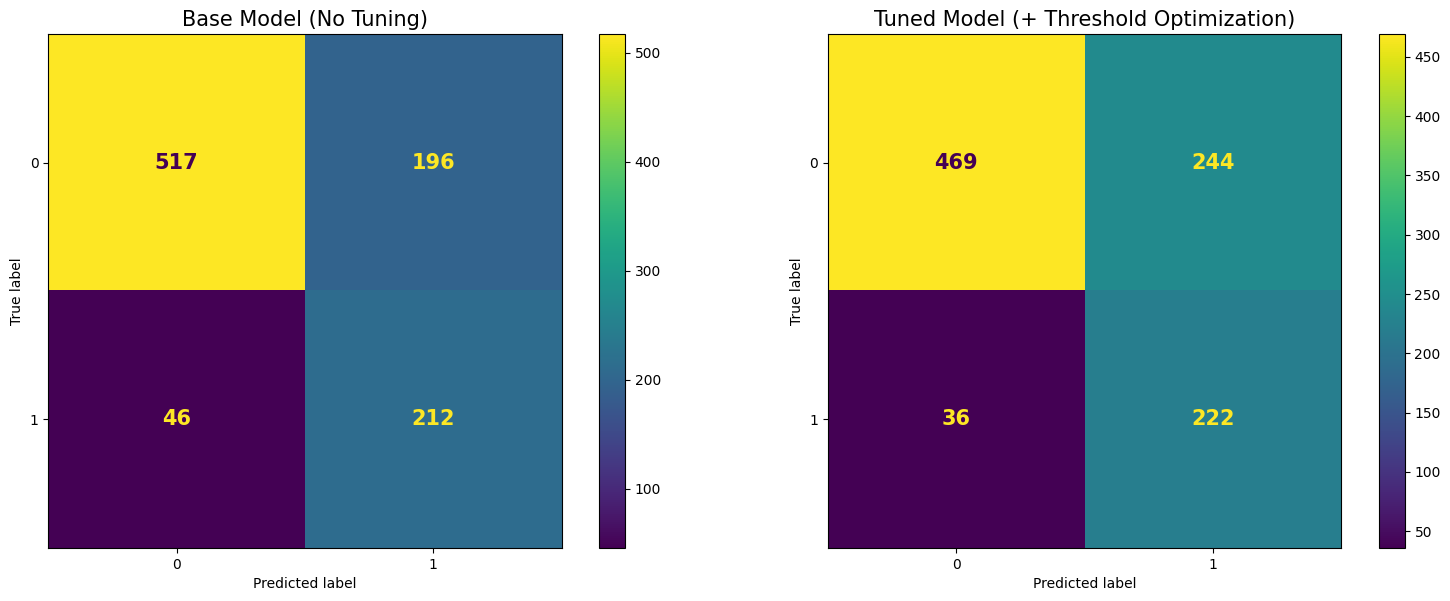

In [72]:
# Visualize confusion matrices
figure, axes = plt.subplots(ncols=2, figsize=(16, 6))

text_format = {'size': 15, 'weight': 'bold'}

ConfusionMatrixDisplay(conf_matrix_base).plot(ax=axes[0], text_kw=text_format)
axes[0].set_title("Base Model (No Tuning)", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_tuned).plot(ax=axes[1], text_kw=text_format)
axes[1].set_title("Tuned Model (+ Threshold Optimization)", fontsize=15)

plt.tight_layout()
plt.show()

Sebelum Tuning – Ada Boost Classifier

- True Negative (TN): 517 pelanggan tidak churn, dan berhasil diprediksi dengan benar.
- True Positive (TP): 212 pelanggan churn berhasil dikenali oleh model.
- False Positive (FP): 196 pelanggan sebenarnya tidak churn, tapi diprediksi akan churn.
- False Negative (FN): 46 pelanggan yang seharusnya churn justru tidak terdeteksi oleh model.

Model cukup baik mengenali pelanggan churn, namun masih terdapat jumlah FN yang signifikan (46) — artinya pelanggan berisiko churn bisa luput dari perhatian jika tidak ditindaklanjuti.

Jumlah FP juga tinggi (196), bisa berdampak pada upaya retensi yang sia-sia pada pelanggan yang sebenarnya tidak berniat churn.

Sesudah Tuning – Ada Boost Classifier
- True Negative (TN): 469 pelanggan tidak churn diprediksi dengan benar.
- True Positive (TP): 222 pelanggan churn berhasil diprediksi dengan tepat.
- False Positive (FP): 244 pelanggan sebenarnya tidak churn namun diprediksi akan churn.
- False Negative (FN): 36 pelanggan yang seharusnya churn tidak terdeteksi.

Setelah tuning, model lebih baik dalam mendeteksi pelanggan yang benar-benar churn (TP naik, FN turun).

Namun, ada kenaikan FP, artinya lebih banyak pelanggan tidak churn yang salah diprediksi akan churn — ini berpotensi menyebabkan upaya retensi yang tidak efisien.

In [73]:
y_test.value_counts()

churn
0    713
1    258
Name: count, dtype: int64

Tujuan dari project ini adalah untuk memprediksi apakah seorang pelanggan akan melakukan churn (berhenti berlangganan) dari layanan Telco, sehingga perusahaan dapat melakukan tindakan preventif yang tepat dan efisien dari sisi biaya.

- False Positive (FP): Model memprediksi pelanggan akan churn. Maka perusahaan memberikan promosi/inisiatif retensi ($100 per pelanggan), namun sebenarnya pelanggan tidak akan churn.
- False Negative (FN): Model memprediksi pelanggan tidak akan churn. Maka perusahaan tidak akan mengambil tindakan apa-apa, padahal pelanggan churn. Akibatnya perusahaan kehilangan pelanggan bernilai tinggi ($500 per pelanggan).

Asumsi: Pelanggan yang diberikan promosi akan tetap bertahan (tidak churn).

**Cost False Positive (FP): $100**

**Cost False Negative (FN): $500**


**Tanpa menggunakan Machine Learning**

Sebelum menggunakan Machine Learning, perusahaan tidak mengetahui siapa saja customer yg akan churn, sehingga harus mengeluarkan cost untuk promosi ke semua customer. Perusahaan tidak mau ambil resiko karena cost kehilangan customer lebih besar.

Kita asumsikan ketika seorang customer diberikan promosi, maka customer tersebut tidak akan churn.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 0             | 713          |
| Actual (1)      | 0             | 258           |

- Total biaya promosi (seluruh pelanggan):
971 × $100 = $97,100
- Promosi yang tepat sasaran (untuk 258 pelanggan churn):
258 × $100 = $25,800
- Biaya promosi yang sia-sia ke pelanggan loyal:
713 × $100 = $71,300

**Dengan menggunakan Machine Learning**

Setelah menggunakan Machine Learning, perusahaan jadi bisa memprediksi siapa saja customer yg akan churn, sehingga bisa mengeluarkan cost untuk promosi lebih tepat sasaran.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 469	          | 244           |
| Actual (1)      | 36            | 222           |

- False Positive (FP):
244 × $100 = $24,400 (biaya promosi ke pelanggan loyal)
- False Negative (FN):
36 × $500 = $18,000 (kehilangan customer karena tidak dipromosikan)
- Total kerugian:
$24,400 + $18,000 = $42,400

**Kerugian menurun setelah pakai Machine Learning**
- Mengurangi biaya promosi yang tidak efektif
- Meskipun ada risiko kehilangan sebagian pelanggan churn (FN), kerugian karena promosi ke pelanggan yang tidak perlu jauh lebih besar tanpa Machine Learning.
- Machine Learning berhasil menurunkan kerugian sampai 40% dari total kerugian sebelumnya

## **16. Feature Importance**

In [74]:
pipe_tuned

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [75]:
from lime.lime_tabular import LimeTabularExplainer

In [76]:
X_train_prep = pipe_tuned.named_steps['preprocessing'].transform(X_train)
X_test_prep = pipe_tuned.named_steps['preprocessing'].transform(X_test)

In [77]:
X_train_arr = np.array(X_train_prep)
X_test_arr = np.array(X_test_prep)

In [78]:
#Explainer Based
explainer = LimeTabularExplainer(
    training_data=X_train_arr,
    training_labels=y_train,
    feature_names=pipe_tuned.named_steps['preprocessing'].get_feature_names_out(),
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

In [79]:
X_test_prep.iloc[0]

num__tenure                                  53.0
num__monthlycharges                          77.4
cat__dependents_Yes                          0.0 
cat__onlinesecurity_No internet service      0.0 
cat__onlinesecurity_Yes                      1.0 
cat__onlinebackup_No internet service        0.0 
cat__onlinebackup_Yes                        0.0 
cat__internetservice_Fiber optic             0.0 
cat__internetservice_No                      0.0 
cat__deviceprotection_No internet service    0.0 
cat__deviceprotection_Yes                    1.0 
cat__techsupport_No internet service         0.0 
cat__techsupport_Yes                         1.0 
cat__contract_One year                       1.0 
cat__contract_Two year                       0.0 
cat__paperlessbilling_Yes                    0.0 
Name: 1245, dtype: float64

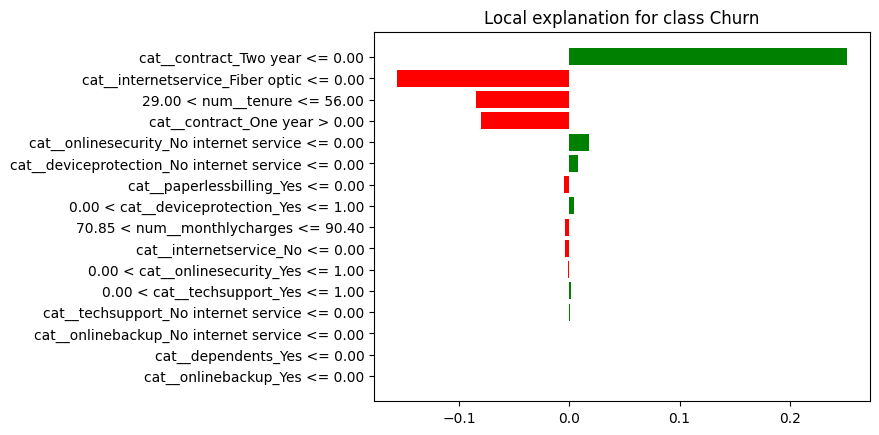

In [80]:
exp = explainer.explain_instance(
    X_test_arr[0],
    pipe_tuned.named_steps['modeling'].predict_proba,
    num_features=16
)

fig = exp.as_pyplot_figure();

**Insight:**
- Fitur 'Contract' memiliki pengaruh paling besar terhadap prediksi churn pelanggan. Pelanggan dengan kontrak jangka panjang (One year, Two year) cenderung memiliki risiko churn lebih rendah dibandingkan kontrak bulanan (Month-to-month).

- Fitur 'Tenure' juga sangat penting, menunjukkan bahwa semakin lama pelanggan berlangganan, semakin kecil kemungkinan mereka untuk churn.

- Fitur 'Internet Service' menunjukkan bahwa jenis layanan internet yang dipilih pelanggan mempengaruhi risiko churn. Pelanggan dengan layanan Fiber optic memiliki risiko churn lebih tinggi dibandingkan DSL atau tanpa layanan internet. Hal ini bisa jadi karena biaya layanan Fiber optic yang lebih tinggi dibandingkan DSL atau tanpa layanan internet.

## **17. Kesimpulan dan Rekomendasi**

### **Kesimpulan**
1. **Churn pelanggan merupakan masalah signifikan** bagi perusahaan telekomunikasi Telco, dengan sekitar 26.5% pelanggan berhenti berlangganan. Ini menunjukkan **perlunya strategi retensi pelanggan yang efektif** yang perlu dilakukan oleh perusahaan.

2. Model machine learning yang dikembangkan, yaitu **AdaBoostClassifier** dengan hyperparameter tuning, berhasil memprediksi pelanggan yang berisiko churn dengan **F2-score sebesar 0.735** pada test set. 
    - Model ini menunjukkan **kemampuan yang baik dalam mendeteksi pelanggan churn (recall 0.86), meskipun precisionnya menurun menjadi 0.48**.
    - Tuning hyperpatameter berhasil meningkatkan performa model dalam mengenali pelanggan yang benar-benar akan churn. **F2-Score dipilih sebagai metrik karena dampak biaya False Negative (kehilangan pelanggan, $500) lebih besar dibanding False Positive($100)**.

3. Evaluasi model menunjukkan bahwa **model tidak mengalami overfitting atau data leakage**, sehingga hasil evaluasi dapat dipercaya untuk interpretasi bisnis selanjutnya.

4. **Efisiensi biaya berhasil ditingkatkan dengan penggunaan model machine learning, mengurangi kerugian hingga 40%** dibandingkan pendekatan tanpa machine learning.
    - Tanpa Machine Learning: Total kerugian $71,300
    - Dengan Machine Learning: Total kerugian $42,400
    - Penghematan biaya: $28,900 (40.5% pengurangan kerugian)\

5. Pengaruh Fitur terhadap Prediksi Churn:
    - **Fitur 'Contract' memiliki pengaruh paling besar terhadap prediksi churn pelanggan**. Pelanggan dengan kontrak jangka panjang (One year, Two year) cenderung memiliki risiko churn lebih rendah dibandingkan kontrak bulanan (Month-to-month).
    - **Fitur 'Tenure' juga sangat penting**, menunjukkan bahwa semakin lama pelanggan berlangganan, semakin kecil kemungkinan mereka untuk churn.
    - **Fitur 'Internet Service' menunjukkan bahwa jenis layanan internet yang dipilih pelanggan mempengaruhi risiko churn**. Pelanggan dengan layanan Fiber optic memiliki risiko churn lebih tinggi dibandingkan DSL atau tanpa layanan internet. Hal ini bisa jadi karena biaya layanan Fiber optic yang lebih tinggi dibandingkan DSL atau tanpa layanan internet.

### **Rekomendasi**

1. **Model akan semakin akurat jika data yang digunakan mencakup lebih banyak aspek customer behavior**. Misalnya:
    - **Riwayat pembayaran** (tepat waktu atau sering menunggak).
    - **Informasi demografi** (usia, lokasi, tingkat pendapatan, jenis tempat tinggal).

2. **Fokus pada pelanggan dengan probabilitas churn tinggi** agar biaya marketing yang dikeluarkan untuk promosi atau campaign bisa lebih efisien.

3. **Develop strategi untuk Customer Retention** untuk mengurangi churn, seperti :
    - Penawaran kontrak tahunan
    - Loyalty Program untuk New Customer
    - Bundling package layanan internet dan telepon

4. **Lakukan sistem monitoring model dan evaluasi berkala**. Seperti :
    - Buat dashboard churn prediction untuk memantau metrik utama seperti recall, precision, dan churn rate aktual tiap bulan.
    - **Lakukan retraining model secara rutin** (misalnya setiap 6 bulan) agar **model tetap relevan dengan customer behavior yang dinamis**. 




## **18. Save Final Model**

In [81]:
#best model
pipe_tuned


,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [82]:
#fitting
pipe_tuned.fit(X,y)

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [83]:
#save pickle
pickle.dump(pipe_tuned, open('model_adaboost.sav', 'wb'))

In [84]:
#load model
model_load = pickle.load(open('model_adaboost.sav', 'rb'))
model_load

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [85]:
# y actual = 1 = churn
y[0]

np.int64(1)

In [86]:
# prediksi customer index 0 
df.iloc[[0], :]

,dependents,tenure,onlinesecurity,onlinebackup,internetservice,deviceprotection,techsupport,contract,paperlessbilling,monthlycharges,churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.9,1


In [87]:
# prediksi customer index 1
df.iloc[[1], :]

,dependents,tenure,onlinesecurity,onlinebackup,internetservice,deviceprotection,techsupport,contract,paperlessbilling,monthlycharges,churn
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,0
